# Full vehicle model

In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt

## Drive cycle import

In [3]:
df_drivecycle = pd.read_excel(r'drive_cycles\drive_cycle_itr2.xlsx', sheet_name = 'itr2_avg')

## Parameters

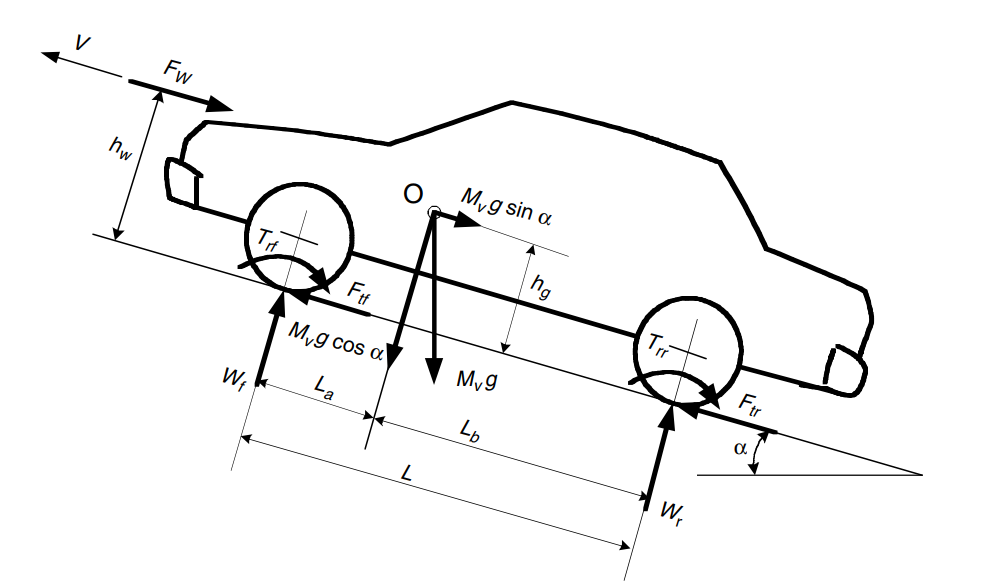

In [ ]:
plt.plot(x = )

### vehicle parameters (select - 0)

In [3]:
vehicle_param = {'mass': 290, #kg
                 'g' : 9.81, #m/s^2 
                 'c_rr': 0.017,
                 'c_d': 0.9,
                 'f_area': 0.42, #m^2
                 'rho': 1.2, #kg/m^3
                 'gradient': 0, #deg
                 'v_air': 0, #tail wind in vehicle direction kmph
                 'wb' : 1.340, #m
                 'x_cg': .713, #m
                 'z_cg': .633, #m
                 'w_r' : 0.3, #m (average radius of front and rear wheel)
                 'i_whl' : 0.42, #kgm2 rolling inertia of wheel
                 'Eff_chain': 0.99,
                 'R_whl_gb': 3.294, # reduction ratio between gearbox and wheel
                 'i_gb' : 0.002, #kgm2
                 'Eff_gb' : 0.99,
                 'R_gb_mtr' : 1.676, # reduction ratio between gearbox and motor
                 'i_mtr' : 0.004 #kgm2
                 }


### coastdown parameters (select - 1)

In [4]:
coastdown_param = {'A' :48.78, #N
                   'B' :0, #N/kmph
                   'C' :0.025 #N/kmph^2
                   }

## Vehicle Force model

### Force Model

In [5]:
veh0_coast1 = 0

In [6]:
if veh0_coast1 == 0:
    # Fr = (0.01*(1+df_drivecycle['avg_speed_kmph'].to_numpy()/(3.6*100)))*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient'])) #for speed under 128kmph
    Fr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient']))
    Far = (0.5*vehicle_param['rho']*vehicle_param['f_area']*vehicle_param['c_d']/3.6**2)*(df_drivecycle['avg_speed_kmph'].to_numpy()+vehicle_param['v_air'])**2
    Fgr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.sin(math.radians(vehicle_param['gradient']))
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2'].to_numpy()
    Fr = Fr+Far+Fgr+Fac
    print('F_calc')
else:
    Fr = coastdown_param['A']
    Far = coastdown_param['C']*df_drivecycle['avg_speed_kmph']**2
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2']
    Fr = Fr + Far + Fac
    print('F_coast')

F_calc


### Roational resistance model

#### wheel

In [7]:
Tr = Fr*vehicle_param['w_r'] #Nm

In [8]:
Td_whl = Tr
# drive_Td_whl = np.clip(Tr, a_min = 0, a_max = None)
alpha_whl = df_drivecycle['avg_accn_mps2'].to_numpy()/vehicle_param['w_r']
torque_whl = alpha_whl * vehicle_param['i_whl']
itorque_whl = Td_whl + torque_whl
rpm_whl = ((df_drivecycle['avg_speed_kmph'].to_numpy()/3.6)/(2*math.pi*vehicle_param['w_r']))*60

#### gearbox

In [9]:
T_gb = itorque_whl/(vehicle_param['R_whl_gb']*vehicle_param['Eff_chain'])
alpha_gb = alpha_whl * vehicle_param['R_whl_gb']
torque_gb = alpha_gb * vehicle_param['i_gb']
itorque_gb = T_gb + torque_gb
rpm_gb = rpm_whl * vehicle_param['R_whl_gb']

#### motor

In [10]:
T_mtr = itorque_gb/(vehicle_param['R_gb_mtr']*vehicle_param['Eff_gb'])
alpha_mtr = alpha_gb * vehicle_param['R_gb_mtr']
torque_mtr = alpha_mtr * vehicle_param['i_mtr']
itorque_mtr = T_mtr + torque_mtr
rpm_mtr = rpm_gb * vehicle_param['R_gb_mtr']

#### drive forces

In [11]:
drive_itorque_whl = np.clip(itorque_whl, a_min = 0, a_max = None)
drive_itorque_gb= np.clip(itorque_gb, a_min = 0, a_max = None)
drive_itorque_mtr = np.clip(itorque_mtr, a_min = 0, a_max = None)

#### braking forces

In [12]:
brake_itorque_whl = np.clip(itorque_whl, a_min = None, a_max = 0)
brake_itorque_gb= np.clip(itorque_gb, a_min = None, a_max = 0)
brake_itorque_mtr = np.clip(itorque_mtr, a_min = None, a_max = 0)

## Motor and motor map

## Regen